In [1]:
import configparser
import os
import pandas as pd
import math
import psycopg2
import numpy as np

from scipy import stats
from statsmodels.stats.proportion import proportions_ztest

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# DB setup
DB_CONFIG = {
    "dbname": "Data_analytics",
    "user": "postgres",
    "password": "1234",
    "host": "127.0.0.1",
    "port": "5432"
}

# The analysis checks whether AOV differs significantly across regions. In case of significant results, a post-hoc Tukey HSD test is applied to identify which regions differ from each other

In [3]:
query = """
WITH max_date_cte AS (
    SELECT MAX(date_id) AS max_date
    FROM fact.fact_sales_case
)
SELECT
    dr.region,
    fs.revenue::numeric / NULLIF(fs.transactions, 0) AS aov
FROM fact.fact_sales_case fs
JOIN dim.dim_stores_case ds ON fs.store_id = ds.store_id
JOIN dim.dim_regions_case dr ON ds.region_id = dr.region_id
CROSS JOIN max_date_cte md
WHERE fs.date_id >= md.max_date - INTERVAL '90 day';
"""

# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql(query, conn)
conn.close()

C:\Users\panty\AppData\Local\Temp/ipykernel_27464/4289429433.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [5]:
model = ols('aov ~ C(region)', data = df).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)
print(anova_table)

                  sum_sq       df            F  PR(>F)
C(region)  649396.761968     29.0  5337.798635     0.0
Residual   196862.715273  46926.0          NaN     NaN


The ANOVA results show a very large F-value (F(29, 46,926) = 5337.80) and a p-value that rounds to zero. This means it’s extremely unlikely that the differences in average order value (AOV) between regions happened by chance. In other words, we can confidently reject the idea that all regions have the same mean AOV - some regions clearly perform differently from others.

In [6]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey HSD
tukey = pairwise_tukeyhsd(endog = df["aov"],     # dependent variable
                          groups = df["region"], # factor (regions)
                          alpha = 0.05)          # significance level

print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1          group2     meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------
      Andalusia          Attica    4.696    0.0   4.3738   5.0183   True
      Andalusia        Auvergne  -0.6246    0.0  -0.9211   -0.328   True
      Andalusia         Bavaria  11.1953    0.0  10.9023  11.4883   True
      Andalusia     Brandenburg  -0.4085 0.0004  -0.7216  -0.0954   True
      Andalusia        Brittany    2.813    0.0   2.5249   3.1011   True
      Andalusia        Calabria  -0.4163    0.0  -0.7003  -0.1322   True
      Andalusia       Catalonia   2.8481    0.0   2.5476   3.1487   True
      Andalusia        Flanders   8.8752    0.0   8.5999   9.1504   True
      Andalusia Hauts-de-France   0.3314  0.003    0.053   0.6098   True
      Andalusia           Hesse   8.8672    0.0   8.5671   9.1674   True
      Andalusia   Ile-de-France   9.0894    0.0   8

After running the **Tukey Honestly Significant Difference (HSD) post-hoc test** on the ANOVA results, we can compare the mean values of the variable AOV across all the regions.

Most regional pairs show statistically significant differences (reject = True), meaning the average values of AOV are not equal between those regions at the 5% significance level.

- Regions such as Bavaria, North Holland, Ile-de-France, and Flanders tend to have much higher mean AOV values than regions like North-East, Calabria, or Sicily.

- Southern and Eastern regions (e.g., Calabria, Sicily, Podkarpackie) generally exhibit lower means.

- Central and Northern regions (e.g., Bavaria, Flanders, North Holland, Hesse) are consistently higher in comparison.

A few pairs, however, show no significant difference (reject = False). For example:

- Andalusia vs Podkarpackie and Andalusia vs Wallonia have p-values greater than 0.05, suggesting similar mean AOV values.

- Attica vs Porto also shows no significant difference.

- Brandenburg vs Calabria and Brittany vs Catalonia are other pairs with similar means.

- Some regions, like Flanders vs Hesse or Auvergne vs Calabria, also fall into this "no significant difference" category.

# Hypothesis: "Regions with lower income and smaller populations tend to exhibit constrained demand potential"

In [7]:
query = """
WITH max_date_cte AS (
    SELECT MAX(date_id) AS max_date
    FROM fact.fact_sales_case
)
SELECT 
    dr.region,
    CASE
        WHEN ds.opening_date >= md.max_date - INTERVAL '1 year'
        THEN 'new'
        ELSE 'old'
    END AS store_age,
    AVG(fs.revenue::NUMERIC / NULLIF(fs.transactions, 0)) AS avg_check,
    dr.avg_income,
    dr.population
FROM fact.fact_sales_case fs
JOIN dim.dim_stores_case ds ON fs.store_id = ds.store_id
JOIN dim.dim_regions_case dr ON ds.region_id = dr.region_id
CROSS JOIN max_date_cte md
WHERE fs.date_id >= md.max_date - INTERVAL '90 day'
GROUP BY dr.region, store_age, dr.avg_income, dr.population
ORDER BY dr.region, store_age;
"""

# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql(query, conn)
conn.close()

C:\Users\panty\AppData\Local\Temp/ipykernel_27464/2618975490.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [8]:
X = df[['avg_income', 'population', 'store_age']] 
y = df['avg_check']

# encoding a categorical variable
X = pd.get_dummies(X, drop_first = True)

X = X.astype(float)

model = sm.OLS(y, X).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:              avg_check   R-squared (uncentered):                   0.988
Model:                            OLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              1453.
Date:                Mon, 06 Oct 2025   Prob (F-statistic):                    4.22e-50
Time:                        12:07:31   Log-Likelihood:                         -118.62
No. Observations:                  55   AIC:                                      243.2
Df Residuals:                      52   BIC:                                      249.3
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [9]:
# Filter out zero or negative values
df = df[(df['avg_income'] > 0) & (df['avg_check'] > 0)]

# Take natural logarithms
df['ln_avg_income'] = np.log(df['avg_income'])
df['ln_avg_check'] = np.log(df['avg_check'])

# Select features and encode categorical variables
X = df[['ln_avg_income', 'population', 'store_age']]
X = pd.get_dummies(X, drop_first = True)

# Force numeric type for all columns
X = X.astype(float)
y = pd.to_numeric(df['ln_avg_check'], errors = 'coerce')

# Drop any rows with NaN
data = pd.concat([X, y], axis = 1).dropna()
X = data[X.columns]
y = data[y.name]

# Fit log-log OLS regression
model = sm.OLS(y, sm.add_constant(X)).fit()
print(model.summary())

# Calculate the effect of a 10% increase in income
gamma = model.params['ln_avg_income']
se_gamma = model.bse['ln_avg_income']

# Exact percent change in AOV
percent_change = (np.exp(gamma * np.log(1.10)) - 1) * 100

# 95% confidence interval
z = 1.96
gamma_lo = gamma - z * se_gamma
gamma_hi = gamma + z * se_gamma

percent_change_lo = (np.exp(gamma_lo * np.log(1.10)) - 1) * 100
percent_change_hi = (np.exp(gamma_hi * np.log(1.10)) - 1) * 100

print(f"\nAOV elasticity w.r.t income: {gamma:.4f}")
print(f"10% increase in income → AOV increase: {percent_change:.2f}%")
print(f"95% confidence interval: [{percent_change_lo:.2f}%, {percent_change_hi:.2f}%]")

                            OLS Regression Results                            
Dep. Variable:           ln_avg_check   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     129.5
Date:                Mon, 06 Oct 2025   Prob (F-statistic):           7.70e-24
Time:                        12:07:31   Log-Likelihood:                 57.832
No. Observations:                  55   AIC:                            -107.7
Df Residuals:                      51   BIC:                            -99.64
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -3.9674      0.593     -6.694

# Hypothesis: "Even within a single region, stores exhibit substantial performance differences, reflecting managerial and operational factors"

In [10]:
query = """
WITH max_date_cte AS (
    SELECT MAX(date_id) AS max_date
    FROM fact.fact_sales_case
)
SELECT
    fs.revenue,
    dr.avg_income,
    CASE
        WHEN ds.opening_date >= md.max_date - INTERVAL '1 year'
        THEN 'new'
        ELSE 'old'
    END AS store_age,
    dr.region
FROM fact.fact_sales_case fs
JOIN dim.dim_stores_case ds ON fs.store_id = ds.store_id
JOIN dim.dim_regions_case dr ON ds.region_id = dr.region_id
CROSS JOIN max_date_cte md
WHERE fs.date_id >= md.max_date - INTERVAL '90 day';
"""

# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql(query, conn)
conn.close()

C:\Users\panty\AppData\Local\Temp/ipykernel_27464/3319107094.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [11]:
import statsmodels.formula.api as smf

# Convert 'store_age' to a categorical variable so that it's treated as a factor in the model
df['store_age'] = df['store_age'].astype('category')

# Mixed-effects model with a random intercept for each region
# Equivalent to the lme4 formula in R: revenue ~ avg_income + store_age + (1 | region)
# This means:
# - Fixed effects: avg_income and store_age
# - Random effects: intercepts vary by region (captures regional differences not explained by the predictors)
model = smf.mixedlm(
    formula="revenue ~ avg_income + store_age",
    data=df,
    groups=df["region"]
)

# Fit the model to the data using maximum likelihood estimation
result = model.fit()
print(result.summary())

               Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    revenue     
No. Observations:     46956      Method:                REML        
No. Groups:           30         Scale:                 274962.0536 
Min. group size:      895        Log-Likelihood:        -360742.8559
Max. group size:      2601       Converged:             Yes         
Mean group size:      1565.2                                        
--------------------------------------------------------------------
                   Coef.   Std.Err.    z    P>|z|   [0.025   0.975] 
--------------------------------------------------------------------
Intercept         -866.731   79.802 -10.861 0.000 -1023.140 -710.321
store_age[T.old]   755.990    8.421  89.777 0.000   739.486  772.495
avg_income           0.084    0.002  37.336 0.000     0.080    0.089
Group Var        20632.824   10.609                                 



There are **systematic regional factors (managerial and operational drivers)** that impact sales beyond income or store age - the regional variance (20633) shows that some regions consistently over- or underperform compared to the average.

The model shows that, on average (holding other factors constant), for each additional 1 unit of average regional income, revenue increases by 0.084 units, p-value < 0.001 → Revenue is highly sensitive to customers’ purchasing power.

On average, "old" stores generate about 756 more revenue units than "new" stores, keeping income constant. This gap is large and statistically significant (p < 0.001) → Established stores perform better - likely due to brand familiarity, customer loyalty, and optimized operations. New stores may need 1–2 years to reach maturity.

# Hypothesis: "Demand structure: regional demand profiles differ - some markets are frequency-driven, while others are value- or price-driven with higher average checks"

In [19]:
query = """
WITH max_date_cte AS (
    SELECT MAX(date_id) AS max_date
    FROM fact.fact_sales_case
)
SELECT 
    dr.region,
    CASE 
        WHEN dr.avg_income >= 45000 THEN 'Rich'
        WHEN dr.avg_income <= 26000 THEN 'Depressed'
        ELSE 'Moderate'
    END AS region_group,
    SUM(fs.revenue) AS total_revenue,
    SUM(fs.transactions) AS total_transactions,
    SUM(fs.revenue)::NUMERIC / NULLIF(SUM(fs.transactions), 0) AS avg_check
FROM fact.fact_sales_case fs
JOIN dim.dim_stores_case ds ON fs.store_id = ds.store_id
JOIN dim.dim_regions_case dr ON ds.region_id = dr.region_id
CROSS JOIN max_date_cte md
WHERE fs.date_id >= md.max_date - INTERVAL '90 day'
GROUP BY dr.region, region_group
ORDER BY dr.region;
"""

# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql(query, conn)
conn.close()

C:\Users\panty\AppData\Local\Temp/ipykernel_27464/194628002.py:27: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


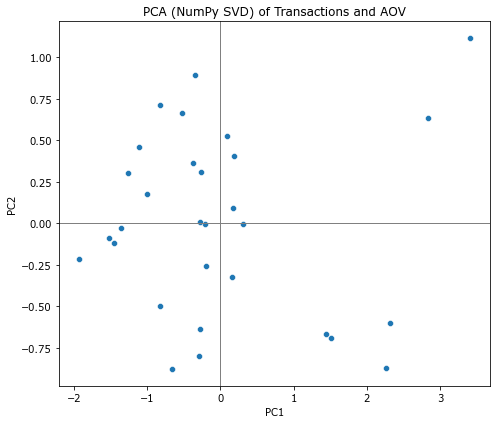

In [14]:
# 1) Build feature matrix and standardize (z-score)
X_raw = df[['total_transactions','avg_check']].values.astype(float)
means = X_raw.mean(axis = 0)
stds = X_raw.std(axis = 0, ddof = 0)
X = (X_raw - means) / stds

# 2) PCA via SVD
U, S, Vt = np.linalg.svd(X, full_matrices = False)
# Components (loadings) are rows of Vt; eigenvalues are S^2/(n-1)
n = X.shape[0]
explained_variance = (S ** 2) / (n - 1)
total_var = explained_variance.sum()
explained_variance_ratio = explained_variance / total_var

# Scores (PC coordinates)
X_pca = U * S

# Prepare outputs
pca_df = pd.DataFrame({'region': df['region'], 'PC1': X_pca[:,0], 'PC2': X_pca[:,1]})
loadings = Vt  # shape (2,2)

# Scatter of PCs
plt.figure(figsize = (7,6))
sns.scatterplot(data=pca_df, x = 'PC1', y = 'PC2')
plt.axhline(0, color = 'gray', linewidth = 1)
plt.axvline(0, color = 'gray', linewidth = 1)
plt.title('PCA (NumPy SVD) of Transactions and AOV')
plt.tight_layout()
plt.show()

if 'pca_df' not in globals():
    import numpy as np
    X_raw = df[['total_transactions','avg_check']].values.astype(float)
    means = X_raw.mean(axis = 0)
    stds = X_raw.std(axis = 0, ddof = 0)
    X = (X_raw - means) / stds
    U, S, Vt = np.linalg.svd(X, full_matrices = False)
    scores = U * S
    pca_df = pd.DataFrame({'region': df['region'], 'PC1': scores[:,0], 'PC2': scores[:,1]})

top_pc2 = pca_df.nlargest(10, 'PC2')[['region','PC1','PC2']]
bottom_pc2 = pca_df.nsmallest(10, 'PC2')[['region','PC1','PC2']]

In [17]:
print(top_pc2.head())

             region       PC1       PC2
11    Ile-de-France  3.409754  1.117026
20     Podkarpackie -0.350398  0.892239
6          Calabria -0.822900  0.711421
9   Hauts-de-France -0.524273  0.666215
8          Flanders  2.832015  0.633533


Markets with higher PC2 scores are **'price-driven'**: they show a relatively higher average check with a smaller role of purchase frequency. These are regions where revenue is primarily driven by pricing and value perception - customers buy less often, but spend more per transaction. High PC2 - focus on value, premiumization, and upselling."

In [18]:
print(bottom_pc2.head())

     region       PC1       PC2
24  Silesia -0.662881 -0.878152
3   Bavaria  2.258806 -0.872568
1    Attica -0.287152 -0.800193
10    Hesse  1.518089 -0.687975
12   Lisbon  1.438815 -0.667365


Markets with lower PC2 scores are **'volume-driven'**: they have a lower average check, but higher purchase frequency. Here, revenue depends more on transaction volume, supported by broader reach, promotions, and high shopping frequency. Low PC2 - focus on reach and frequency expansion through distribution channels, promotions, and lowering purchase barriers.